# Customer Churn Prediction - Traditional ML Notebook

**Goal:** Build a model to predict customer churn

**Note:** This notebook represents a typical data scientist's workflow with common practices that we'll later improve with ZenML

---

**Today's Date:** 2024-01-15  
**Author:** DataScientist_v2  
**Status:** FINAL VERSION (actually final this time!)

## 📊 Data Loading

Load the customer churn dataset and take a quick look

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/customer_churn.csv')
print(f"Loaded {len(data)} records")
print(f"Columns: {list(data.columns)}")
data.head()

Loaded 2500 records
Columns: ['customer_id', 'age', 'tenure_months', 'monthly_charges', 'total_charges', 'num_services', 'contract_type', 'payment_method', 'internet_service', 'churned']


,customer_id,age,tenure_months,monthly_charges,total_charges,num_services,contract_type,payment_method,internet_service,churned
0,CUST_000000,52,40,108.53,4321.22,4,month-to-month,bank_transfer,Fiber optic,1
1,CUST_000001,42,27,38.85,1067.52,2,one-year,electronic_check,No,0
2,CUST_000002,54,2,32.27,100.00,4,month-to-month,bank_transfer,Fiber optic,1
3,CUST_000003,67,8,95.73,821.81,3,two-year,bank_transfer,No,1
4,CUST_000004,41,8,136.50,1115.77,4,two-year,bank_transfer,DSL,0


In [2]:
# Quick data inspection - all in one cell (typical notebook style)
print("Dataset Info:")
print(data.info())
print("\nMissing values:")
print(data.isnull().sum())
print("\nClass distribution:")
print(data['churned'].value_counts())
print(f"Churn rate: {data['churned'].mean():.1%}")
print("\nBasic stats:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2500 non-null   object 
 1   age               2500 non-null   int64  
 2   tenure_months     2500 non-null   int64  
 3   monthly_charges   2500 non-null   float64
 4   total_charges     2500 non-null   float64
 5   num_services      2500 non-null   int64  
 6   contract_type     2500 non-null   object 
 7   payment_method    2500 non-null   object 
 8   internet_service  2500 non-null   object 
 9   churned           2500 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 195.4+ KB
None

Missing values:
customer_id         0
age                 0
tenure_months       0
monthly_charges     0
total_charges       0
num_services        0
contract_type       0
payment_method      0
internet_service    0
churned             0
dtype: in

## 🔍 Data Exploration

Let's understand our data better with some visualizations

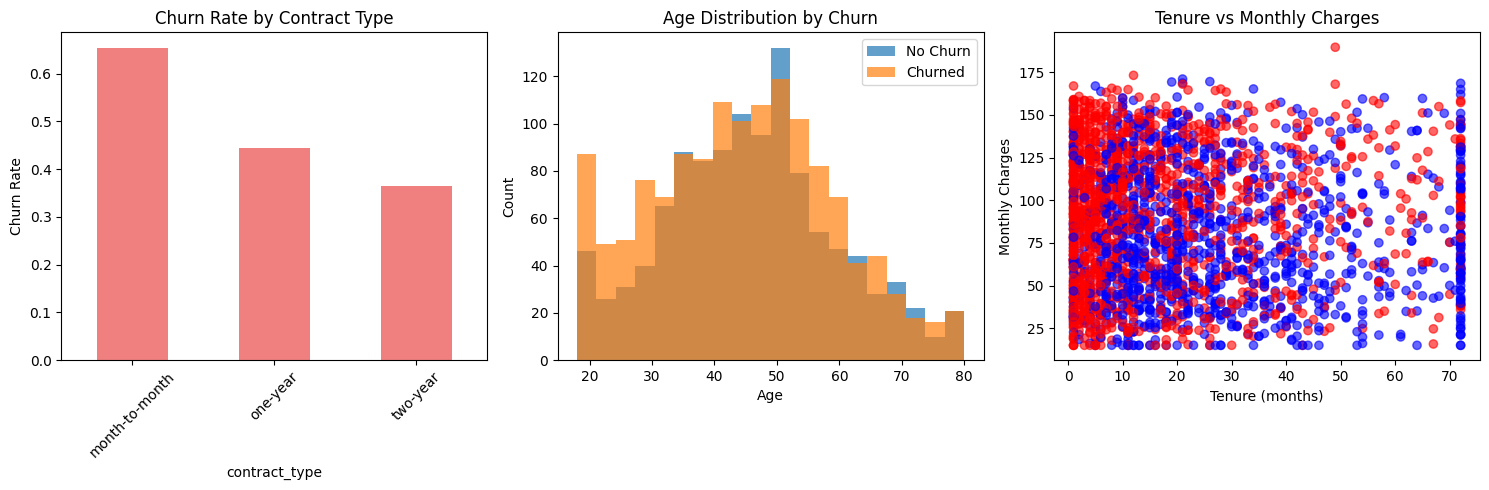

Key insights:
- Month-to-month customers churn at 65.4%
- Two-year customers churn at 36.5%
- Average tenure for churned: 17.4 months
- Average tenure for retained: 27.3 months


In [3]:
# Everything mixed together - plotting, analysis, insights
plt.figure(figsize=(15, 5))

# Churn by contract type
plt.subplot(1, 3, 1)
churn_by_contract = data.groupby('contract_type')['churned'].mean()
churn_by_contract.plot(kind='bar', color='lightcoral')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# Age distribution
plt.subplot(1, 3, 2)
plt.hist(data[data['churned']==0]['age'], alpha=0.7, label='No Churn', bins=20)
plt.hist(data[data['churned']==1]['age'], alpha=0.7, label='Churned', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Churn')
plt.legend()

# Monthly charges vs tenure
plt.subplot(1, 3, 3)
colors = ['blue' if x == 0 else 'red' for x in data['churned']]
plt.scatter(data['tenure_months'], data['monthly_charges'], c=colors, alpha=0.6)
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges')
plt.title('Tenure vs Monthly Charges')

plt.tight_layout()
plt.show()

# Print some insights (mixed with visualization code)
print("Key insights:")
print(f"- Month-to-month customers churn at {churn_by_contract['month-to-month']:.1%}")
print(f"- Two-year customers churn at {churn_by_contract['two-year']:.1%}")
print(f"- Average tenure for churned: {data[data['churned']==1]['tenure_months'].mean():.1f} months")
print(f"- Average tenure for retained: {data[data['churned']==0]['tenure_months'].mean():.1f} months")

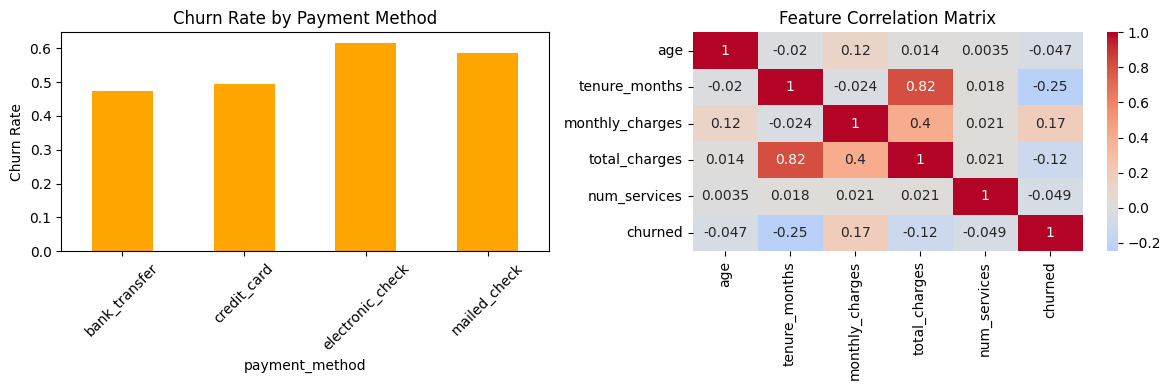


Payment Method Analysis:
- bank_transfer: 47.3% churn rate (651 customers)
- electronic_check: 61.7% churn rate (908 customers)
- mailed_check: 58.8% churn rate (313 customers)
- credit_card: 49.4% churn rate (628 customers)

High-value customers (>$100/month): 956 customers
High-value churn rate: 64.2%

New customers (<6 months): 565 customers
New customer churn rate: 83.2%


In [4]:
# More exploration - payment method analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
payment_churn = data.groupby('payment_method')['churned'].agg(['count', 'mean'])
payment_churn['mean'].plot(kind='bar', color='orange')
plt.title('Churn Rate by Payment Method')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
# Correlation heatmap
numeric_cols = ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'num_services', 'churned']
correlation = data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Print more analysis (inline with plotting)
print("\nPayment Method Analysis:")
for method in data['payment_method'].unique():
    rate = data[data['payment_method']==method]['churned'].mean()
    count = len(data[data['payment_method']==method])
    print(f"- {method}: {rate:.1%} churn rate ({count} customers)")

# Check for interesting patterns
high_value_customers = data[data['monthly_charges'] > 100]
print(f"\nHigh-value customers (>$100/month): {len(high_value_customers)} customers")
print(f"High-value churn rate: {high_value_customers['churned'].mean():.1%}")

new_customers = data[data['tenure_months'] < 6]
print(f"\nNew customers (<6 months): {len(new_customers)} customers")
print(f"New customer churn rate: {new_customers['churned'].mean():.1%}")

## 🔧 Data Preparation

Clean and prepare the data for modeling

In [5]:
# Typical notebook style - everything in one massive cell, no functions
# Create a copy to avoid modifying original (sometimes forgotten)
df = data.copy()

# Drop customer_id (not useful for prediction)
df = df.drop('customer_id', axis=1)

# Encode categorical variables - hardcoded approach
le_contract = LabelEncoder()
df['contract_type_encoded'] = le_contract.fit_transform(df['contract_type'])

le_payment = LabelEncoder()
df['payment_method_encoded'] = le_payment.fit_transform(df['payment_method'])

le_internet = LabelEncoder()
df['internet_service_encoded'] = le_internet.fit_transform(df['internet_service'])

# Drop original categorical columns
df = df.drop(['contract_type', 'payment_method', 'internet_service'], axis=1)

# Separate features and target
X = df.drop('churned', axis=1)
y = df['churned']

print("Features:", list(X.columns))
print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# Split the data - hardcoded parameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train churn rate: {y_train.mean():.1%}")
print(f"Test churn rate: {y_test.mean():.1%}")

# Scale features - but only some of them (inconsistent)
scaler = StandardScaler()
numerical_cols = ['age', 'tenure_months', 'monthly_charges', 'total_charges']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nData preprocessing completed!")
X_train.head()

Features: ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'num_services', 'contract_type_encoded', 'payment_method_encoded', 'internet_service_encoded']
Feature matrix shape: (2500, 8)
Target shape: (2500,)

Train set: 2000 samples
Test set: 500 samples
Train churn rate: 54.5%
Test churn rate: 54.4%

Data preprocessing completed!


,age,tenure_months,monthly_charges,total_charges,num_services,contract_type_encoded,payment_method_encoded,internet_service_encoded
1400,-1.127709,2.509452,-0.134156,1.961763,4,1,1,1
1252,-1.904174,0.248730,-0.663007,-0.060448,1,1,2,1
1044,-0.210069,1.605163,1.028601,2.482813,7,0,0,2
980,0.778159,2.509452,-1.186735,0.427086,5,1,2,0
226,0.001694,0.550159,-1.212357,-0.264698,4,2,1,0


## 🤖 Model Training

Train multiple models to see which performs best

In [6]:
# Train multiple models in one cell - typical notebook pattern
print("Training models...")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
print("✅ Random Forest trained")

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
print("✅ XGBoost trained")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print("✅ Logistic Regression trained")

print("\nAll models trained successfully!")

Training models...
✅ Random Forest trained
✅ XGBoost trained
✅ Logistic Regression trained

All models trained successfully!


## 📈 Model Evaluation

Evaluate all models and pick the best one


=== Random Forest Results ===
Accuracy: 0.662

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       228
           1       0.69      0.69      0.69       272

    accuracy                           0.66       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.66      0.66      0.66       500


=== XGBoost Results ===
Accuracy: 0.650

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63       228
           1       0.69      0.65      0.67       272

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.65      0.65      0.65       500


=== Logistic Regression Results ===
Accuracy: 0.650

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       228
           1       0.66 

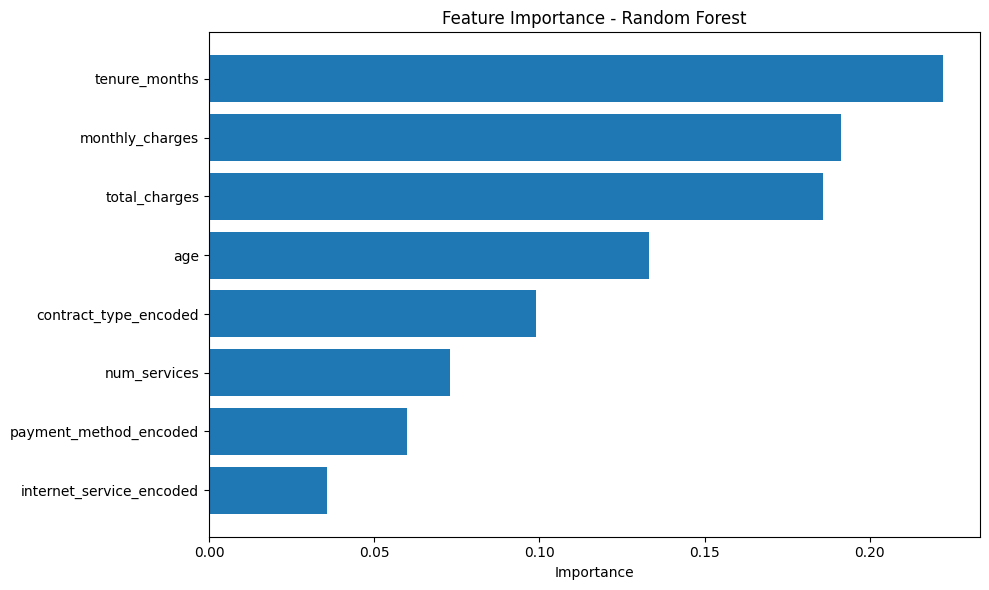

In [7]:
# Predictions and metrics mixed together - no clean separation
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model
}

results = {}

for name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"\n=== {name} Results ===")
    print(f"Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Find best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_accuracy = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} with accuracy: {best_accuracy:.3f}")

# Feature importance for best model (if it has this attribute)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 5 Important Features for {best_model_name}:")
    print(feature_importance.head())
    
    # Quick plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:8], feature_importance['importance'][:8])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

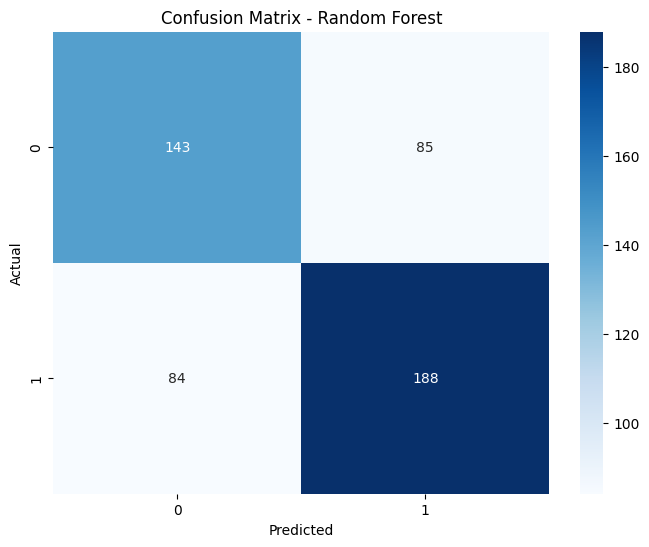

Manual calculations for Random Forest:
Precision: 0.689
Recall: 0.691
F1-Score: 0.690
False Positive Rate: 0.373
False Negative Rate: 0.309


In [8]:
# Confusion matrix and additional metrics
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics manually (typical notebook approach)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Manual calculations for {best_model_name}:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"False Positive Rate: {fp/(fp+tn):.3f}")
print(f"False Negative Rate: {fn/(fn+tp):.3f}")

In [9]:
# Save the best model with terrible naming convention
import os
import pickle
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Terrible naming - no versioning, confusing names
model_filename = 'models/model_final_v2_actually_final_BEST.pkl'
scaler_filename = 'models/scaler_for_model_v2.pkl'
encoders_filename = 'models/label_encoders_final.pkl'

# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)

# Save encoders in a dict
encoders = {
    'contract_type': le_contract,
    'payment_method': le_payment,
    'internet_service': le_internet
}
with open(encoders_filename, 'wb') as f:
    pickle.dump(encoders, f)

print(f"✅ Best model ({best_model_name}) saved as: {model_filename}")
print(f"✅ Scaler saved as: {scaler_filename}")
print(f"✅ Encoders saved as: {encoders_filename}")
print(f"\nModel accuracy: {best_accuracy:.3f}")

# Also save some metadata in a text file (very manual approach)
metadata_file = 'models/model_info_v2.txt'
with open(metadata_file, 'w') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Accuracy: {best_accuracy:.3f}\n")
    f.write(f"Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n")
    f.write(f"Features: {list(X.columns)}\n")

print(f"✅ Model metadata saved as: {metadata_file}")

✅ Best model (Random Forest) saved as: models/model_final_v2_actually_final_BEST.pkl
✅ Scaler saved as: models/scaler_for_model_v2.pkl
✅ Encoders saved as: models/label_encoders_final.pkl

Model accuracy: 0.662
✅ Model metadata saved as: models/model_info_v2.txt


## 🔮 Inference Example

Test the saved model on new data

In [10]:
# Load model and make predictions on new data - hardcoded example
print("Loading saved model for inference...")

# Load everything back (no error handling)
loaded_model = pickle.load(open('models/model_final_v2_actually_final_BEST.pkl', 'rb'))
loaded_scaler = pickle.load(open('models/scaler_for_model_v2.pkl', 'rb'))
loaded_encoders = pickle.load(open('models/label_encoders_final.pkl', 'rb'))

print("✅ Model, scaler, and encoders loaded")

# Create some example new data (hardcoded)
new_customers = pd.DataFrame({
    'age': [25, 45, 65],
    'tenure_months': [3, 24, 60],
    'monthly_charges': [85.5, 65.2, 45.0],
    'total_charges': [250.0, 1500.0, 2700.0],
    'num_services': [2, 4, 3],
    'contract_type': ['month-to-month', 'one-year', 'two-year'],
    'payment_method': ['electronic_check', 'credit_card', 'bank_transfer'],
    'internet_service': ['Fiber optic', 'DSL', 'DSL']
})

print("\nNew customers to predict:")
print(new_customers)

Loading saved model for inference...
✅ Model, scaler, and encoders loaded

New customers to predict:
   age  tenure_months  monthly_charges  total_charges  num_services  \
0   25              3             85.5          250.0             2   
1   45             24             65.2         1500.0             4   
2   65             60             45.0         2700.0             3   

    contract_type    payment_method internet_service  
0  month-to-month  electronic_check      Fiber optic  
1        one-year       credit_card              DSL  
2        two-year     bank_transfer              DSL  


In [11]:
# Apply same transformations as training (manual and error-prone)
new_customers_processed = new_customers.copy()

# Encode categorical variables
new_customers_processed['contract_type_encoded'] = loaded_encoders['contract_type'].transform(new_customers['contract_type'])
new_customers_processed['payment_method_encoded'] = loaded_encoders['payment_method'].transform(new_customers['payment_method'])
new_customers_processed['internet_service_encoded'] = loaded_encoders['internet_service'].transform(new_customers['internet_service'])

# Drop original categorical columns
new_customers_processed = new_customers_processed.drop(['contract_type', 'payment_method', 'internet_service'], axis=1)

# Scale numerical features
numerical_cols = ['age', 'tenure_months', 'monthly_charges', 'total_charges']
new_customers_processed[numerical_cols] = loaded_scaler.transform(new_customers_processed[numerical_cols])

# Make predictions
churn_predictions = loaded_model.predict(new_customers_processed)
churn_probabilities = loaded_model.predict_proba(new_customers_processed)[:, 1]

# Display results
results_df = new_customers.copy()
results_df['churn_prediction'] = churn_predictions
results_df['churn_probability'] = churn_probabilities
results_df['risk_level'] = ['High' if p > 0.7 else 'Medium' if p > 0.4 else 'Low' for p in churn_probabilities]

print("\n🔮 Churn Predictions:")
print(results_df[['age', 'tenure_months', 'contract_type', 'churn_prediction', 'churn_probability', 'risk_level']])

print("\n📊 Summary:")
for i, (_, row) in enumerate(results_df.iterrows()):
    status = "WILL CHURN" if row['churn_prediction'] == 1 else "WILL STAY"
    print(f"Customer {i+1}: {status} (probability: {row['churn_probability']:.1%}, risk: {row['risk_level']})")


🔮 Churn Predictions:
   age  tenure_months   contract_type  churn_prediction  churn_probability  \
0   25              3  month-to-month                 1           0.976629   
1   45             24        one-year                 0           0.098278   
2   65             60        two-year                 0           0.096963   

  risk_level  
0       High  
1        Low  
2        Low  

📊 Summary:
Customer 1: WILL CHURN (probability: 97.7%, risk: High)
Customer 2: WILL STAY (probability: 9.8%, risk: Low)
Customer 3: WILL STAY (probability: 9.7%, risk: Low)


In [12]:
# Let's also test on a batch of existing customers (more realistic)
print("\n🔍 Batch Inference Test on Sample Customers")

# Take a random sample from our dataset for testing
sample_customers = data.sample(10, random_state=123).copy()
sample_customers_display = sample_customers[['customer_id', 'age', 'tenure_months', 'contract_type', 'monthly_charges', 'churned']].copy()

print("Sample customers for prediction:")
print(sample_customers_display)

# Prepare data (copy-paste from above - typical notebook approach)
sample_processed = sample_customers.copy()
sample_processed = sample_processed.drop('customer_id', axis=1)
sample_processed = sample_processed.drop('churned', axis=1)  # Remove target for prediction

# Apply same preprocessing
sample_processed['contract_type_encoded'] = loaded_encoders['contract_type'].transform(sample_processed['contract_type'])
sample_processed['payment_method_encoded'] = loaded_encoders['payment_method'].transform(sample_processed['payment_method'])
sample_processed['internet_service_encoded'] = loaded_encoders['internet_service'].transform(sample_processed['internet_service'])

sample_processed = sample_processed.drop(['contract_type', 'payment_method', 'internet_service'], axis=1)
sample_processed[numerical_cols] = loaded_scaler.transform(sample_processed[numerical_cols])

# Make predictions
batch_predictions = loaded_model.predict(sample_processed)
batch_probabilities = loaded_model.predict_proba(sample_processed)[:, 1]

# Compare with actual
print("\n📈 Prediction vs Actual:")
comparison = pd.DataFrame({
    'customer_id': sample_customers['customer_id'],
    'actual_churn': sample_customers['churned'],
    'predicted_churn': batch_predictions,
    'churn_probability': batch_probabilities,
    'correct': sample_customers['churned'] == batch_predictions
})

print(comparison)
print(f"\nBatch accuracy: {comparison['correct'].mean():.1%}")
print(f"Average prediction confidence: {batch_probabilities.mean():.1%}")


🔍 Batch Inference Test on Sample Customers
Sample customers for prediction:
      customer_id  age  tenure_months   contract_type  monthly_charges  \
2386  CUST_002386   41             64        two-year           140.97   
1298  CUST_001298   49             13        one-year           123.88   
1995  CUST_001995   61              1  month-to-month           108.91   
2097  CUST_002097   28              6  month-to-month            19.65   
289   CUST_000289   35             26        one-year            34.96   
2380  CUST_002380   30              7        two-year            68.67   
2336  CUST_002336   52              2        one-year           123.46   
1492  CUST_001492   36             10        two-year            96.55   
33    CUST_000033   29             26  month-to-month           145.53   
1970  CUST_001970   53             23        two-year            64.80   

      churned  
2386        0  
1298        0  
1995        1  
2097        0  
289         0  
2380        

## 🚨 Problems with This Approach

This notebook demonstrates several issues common in traditional ML workflows:

### 🔴 **Data & Code Issues:**
- **Hardcoded file paths** - breaks when files move
- **Mixed concerns** - data prep, training, evaluation all mixed together
- **No error handling** - fails silently or crashes unexpectedly
- **Inconsistent preprocessing** - manual scaling, encoding
- **Copy-paste code** - preprocessing repeated in inference section

### 🔴 **Reproducibility Issues:**
- **Poor model versioning** - terrible file names like 'model_final_v2_actually_final_BEST.pkl'
- **No experiment tracking** - hard to compare different runs
- **Manual metadata** - error-prone text files for model info
- **No lineage tracking** - can't track what data/code produced which model
- **Environment dependencies** - no clear package versions

### 🔴 **Operational Issues:**
- **Manual inference pipeline** - lots of room for errors
- **No monitoring** - can't track model performance over time
- **Difficult deployment** - how do you productionize this?
- **No collaboration** - hard for teams to work together
- **Data drift detection** - no systematic way to monitor

### 🔴 **Maintainability Issues:**
- **Code duplication** - preprocessing logic repeated
- **Large cells** - everything mixed together
- **No modularity** - can't reuse components
- **Poor documentation** - inline comments and print statements

### 🟢 **How ZenML Solves This:**
- **Structured pipelines** with clear steps and responsibilities
- **Automatic artifact versioning** and lineage tracking
- **Built-in experiment tracking** and model registry
- **Consistent preprocessing** through reusable pipeline steps
- **Easy deployment** and monitoring capabilities
- **Team collaboration** through shared pipeline definitions
- **Environment management** and reproducibility
- **Modular components** that can be tested and reused

---

**Next Step:** Convert this notebook into clean, production-ready ZenML pipelines! 🚀